#### - In the second approach, we will combine all attributes including “author”, “text” and “title” into one column. <br> - Replace null values with spaces(missing data imputation).<br> - Remove stop-words and special characters. <br> - Lemmatization <br> - Finally converting. Count Vectorization and TF-IDF Transformation.

In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import numpy as np # linear algebra
import pandas as pd #data processing
import re

In [2]:
# Reading the datasets
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
#print(train.shape, test.shape)
print("Shape of Training data: ", train.shape)
print("Shape of Testing data: ", test.shape)

Shape of Training data:  (20800, 5)
Shape of Testing data:  (5200, 4)


In [4]:
class_labels  = train['label'].values.tolist()
class_labels_set = set(class_labels)

freq_list = []

for c in class_labels_set:
    freq_list.append(class_labels.count(c))

print ('Freq',freq_list)
print ('number',class_labels_set)

Freq [10387, 10413]
number {0, 1}


<AxesSubplot:xlabel='label', ylabel='count'>

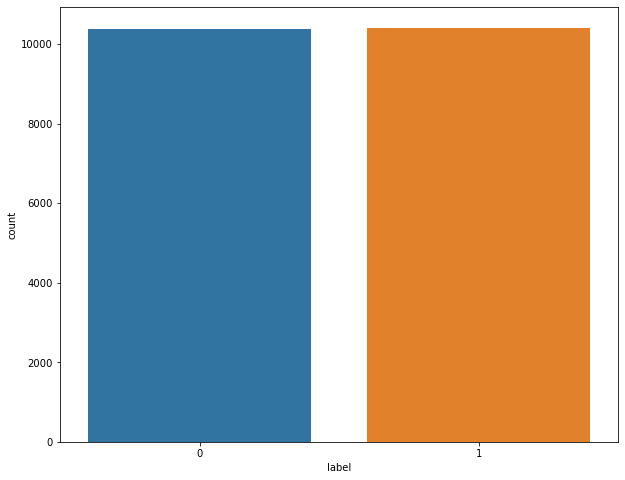

In [5]:
# plotting the number of samples per class
import seaborn as sns
plt.figure(figsize=(10,8))
sns.countplot(x="label", data=train)

Data set is well balanced

In [6]:
train.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [7]:
train.describe()

id         label
count  20800.000000  20800.000000
mean   10399.500000      0.500625
std     6004.587135      0.500012
min        0.000000      0.000000
25%     5199.750000      0.000000
50%    10399.500000      1.000000
75%    15599.250000      1.000000
max    20799.000000      1.000000

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [9]:
train.columns

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')

## Check number of NULL values in the dataset

In [10]:
# how many null values in the dataset
print("Null values in train data:")
print(train.isnull().sum())
print('\n')

print("Null values in test data:")
print(test.isnull().sum())

Null values in train data:
id           0
title      558
author    1957
text        39
label        0
dtype: int64


Null values in test data:
id          0
title     122
author    503
text        7
dtype: int64


<AxesSubplot:>

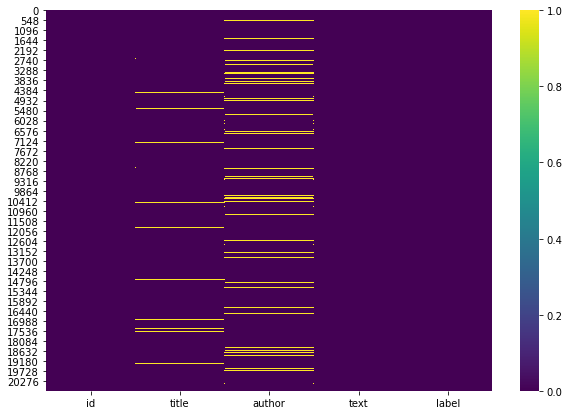

In [11]:
plt.figure(figsize=(10,7))
sns.heatmap(train.isnull(),cmap='viridis')

In [12]:
#Data types of all the attributes
print(train.dtypes)

id         int64
title     object
author    object
text      object
label      int64
dtype: object


## Missing data imputation

#### Datasets may have missing values which can cause problems for many machine learning algorithms. It is better to identify and replace missing values for each column in your input data prior to modeling your prediction task. This is called missing data imputation, or imputing for short.

In [13]:
#imputing the data with spaces
test=test.fillna(' ') 
train=train.fillna(' ') 

<AxesSubplot:>

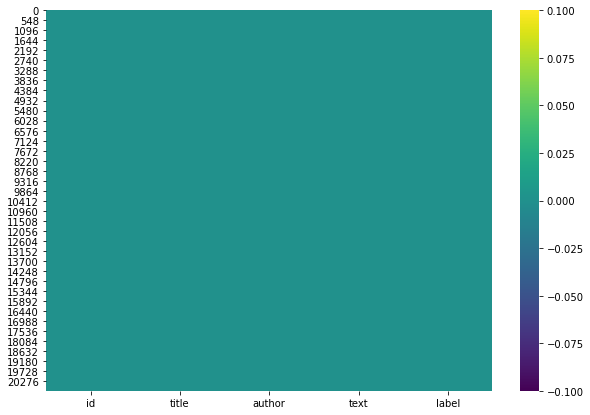

In [14]:
plt.figure(figsize=(10,7))
sns.heatmap(train.isnull(), cmap='viridis')

In [15]:
from sklearn.feature_extraction.text import CountVectorizer 
#Convert a collection of text documents to a matrix of token counts
#transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus) #creating sparse matrix of numpy array type
    sum_words = bag_of_words.sum(axis=0) #matrix with frequencies of different words
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] #list of words with frequencies
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #sort frequencies in descending order
    return words_freq[:n]

the 920586
to 426276
of 418156
and 383023
in 311144
that 217827
is 156845
for 144756
on 130799
it 125228
with 102572
he 102434
was 101727
as 99072
said 80054
by 78684
are 73717
at 73574
have 72417
be 71739


<AxesSubplot:title={'center':'Top 20 words in dataset before removing stop words'}, xlabel='text'>

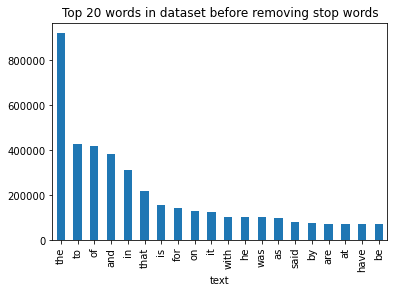

In [16]:
common_words = get_top_n_words(train['text'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=False).plot(
kind='bar', title='Top 20 words in dataset before removing stop words')

of the 98832
in the 74589
to the 41825
on the 30767
and the 27043
for the 25451
that the 24536
to be 23122
at the 22979
with the 18952
from the 18169
by the 17674
mr trump 17341
it is 14755
he said 13319
the united 12730
it was 12454
united states 12371
one of 11490
has been 11352


<AxesSubplot:title={'center':'Top 20 bigrams in dataset before removing stop words'}, xlabel='text'>

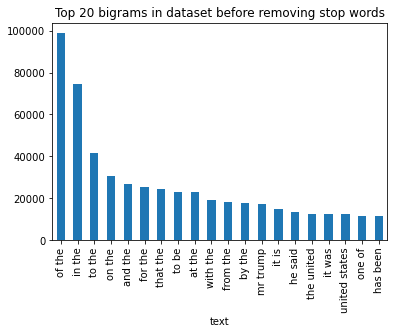

In [17]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(train['text'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df3.groupby('text').sum()['count'].sort_values(ascending=False).plot(
kind='bar', title='Top 20 bigrams in dataset before removing stop words')

<AxesSubplot:title={'center':'Number of True News vs Fake News'}, ylabel='Frequency'>

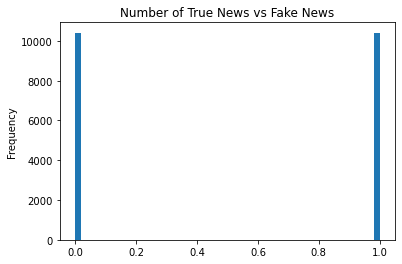

In [18]:
train['label'].plot(kind='hist',bins=50,title='Number of True News vs Fake News')

## Merging the columns (title, author, text) into one column

In [19]:
test['total']=test['title']+' '+test['author']+test['text']
train['total']=train['title']+' '+train['author']+train['text']

In [20]:
train.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                               total  
0  House Dem Aide: We Didn’t Even See Comey’s Let...  
1  FLYNN: Hillary Clinton, Big Woman on Campus - ...  
2  Why the Truth Might Get You Fired Consortiumne...  
3  15 Civilians Killed In Single US Airstrike Hav...  
4  Iranian woman jailed for fictional unpublished...

In [21]:
test.head()

id                                              title  \
0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1  20801  Russian warships ready to strike terrorists ne...   
2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
4  20804                    Keiser Report: Meme Wars (E995)   

                    author                                               text  \
0         David Streitfeld  PALO ALTO, Calif.  —   After years of scorning...   
1                           Russian warships ready to strike terrorists ne...   
2            Common Dreams  Videos #NoDAPL: Native American Leaders Vow to...   
3            Daniel Victor  If at first you don’t succeed, try a different...   
4  Truth Broadcast Network  42 mins ago 1 Views 0 Comments 0 Likes 'For th...   

                                               total  
0  Specter of Trump Loosens Tongues, if Not Purse...  
1  Russian warships ready to strike terrorists ne...  
2  #NoDAPL: Native American Leaders Vow to Stay A...  
3  Tim Tebow Will Attempt Another Comeback, This ...  
4  Keiser Report: Meme Wars (E995) Truth Broadcas...

## Data Cleaning and preprocessing 

# 1. Regex

In [22]:
# Example
#Remove punctuations from the String  
sample = "!</> NLP is $$ </>^sh!!!o%%rt &&%$fo@@@r^^^&&!& </>*Natural@# Language&&\ Pro@@@##%^^&cessing!@# %%$"

In [23]:
# what is gonna get selected we r gonna replace that with the empty string(2nd parameter)
sample = re.sub(r'[^\w\s]','',sample)

In [24]:
print(sample)

 NLP is  short for Natural Language Processing 


# 2. Tokenization

In [25]:
import nltk 
# nltk library is very important for text preprocessing and dealing with the textual data

In [26]:
#Downloading nltk data
# nltk uses some data, punkt will hold some data related to tokenisation
# different functions and techniques of nltk uses different data
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abhiram\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
# Example of tokenisation for sentence
print("The NLTK tokeniser has tokenised \"Computers are not as great at understanding words as they are numbers.\" into a list of tokens ", end="\n\n")
print(nltk.word_tokenize("Computers are not as great at understanding words as they are numbers."))

The NLTK tokeniser has tokenised "Computers are not as great at understanding words as they are numbers." into a list of tokens 

['Computers', 'are', 'not', 'as', 'great', 'at', 'understanding', 'words', 'as', 'they', 'are', 'numbers', '.']


# 3. StopWords

In [28]:
sample_text = "The monsoon is arriving tomorrow. It will rain heavily." 

In [29]:
print("Priniting all the different sentences in sample_text: ", end="\n\n")
for i in nltk.sent_tokenize(sample_text):
    print(i)

Priniting all the different sentences in sample_text: 

The monsoon is arriving tomorrow.
It will rain heavily.


In [30]:
words = nltk.word_tokenize(sample_text)

In [31]:
print("Priniting all the different words in sample_text: ", end="\n\n")
for i in nltk.word_tokenize(sample_text):
    print(i)

Priniting all the different words in sample_text: 

The
monsoon
is
arriving
tomorrow
.
It
will
rain
heavily
.


In [32]:
from nltk.corpus import stopwords
# corpus of nltk will hold the stopwords

In [33]:
stop=stopwords.words("english")
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [34]:
clean_words = [w for w in words if not w in stop]
#Go through each word and add it into new array if it is not a part of the stopwords

In [35]:
for i in clean_words:
    print(i)

The
monsoon
arriving
tomorrow
.
It
rain
heavily
.


In [36]:
words = nltk.word_tokenize(sample_text.lower())

In [37]:
clean_words = [w for w in words if not w in stop]
for i in clean_words:
    print(i)

monsoon
arriving
tomorrow
.
rain
heavily
.


In [38]:
import string
punctuations = list(string.punctuation)

In [39]:
print(punctuations)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [40]:
stop = stop + punctuations
# add punctuations also into stop list

In [41]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [42]:
clean_words = [w for w in words if not w in stop]
clean_words
#clean_words includes all the words in the sentence excluding the stopwords

['monsoon', 'arriving', 'tomorrow', 'rain', 'heavily']

# 4. Lemmatization

In [43]:
from nltk.stem import WordNetLemmatizer
#Using WordNet lemmatizer
lemmatizer=WordNetLemmatizer()

input_str="kites babies corpora meeting is done languages cities mice rocks"

In [44]:
from nltk.tokenize import sent_tokenize, word_tokenize 

In [45]:
#Tokenize the sentence
input_str=nltk.word_tokenize(input_str)

In [46]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Abhiram\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
# import these modules 
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() #need to tokenise the complete sentence


print("Below,kites->kite babies->baby corpora->corpus meeting->meeting languages->language cities->city mice->mouse rocks->roock. Stemming cannot do this", end="\n")
      
#now each token i ll pass to he lemmatizer to see its reduced form
#Lemmatize each word
for word in input_str:
    print(lemmatizer.lemmatize(word).lower())

Below,kites->kite babies->baby corpora->corpus meeting->meeting languages->language cities->city mice->mouse rocks->roock. Stemming cannot do this
kite
baby
corpus
meeting
is
done
language
city
mouse
rock


## Applying Text Preprocessing techniques discussed above on Train data

In [48]:
from nltk.stem import WordNetLemmatizer 
lemmatizer=WordNetLemmatizer()
for index,row in train.iterrows(): #taking he train data and iterating each row
    filter_sentence = ''
    
    sentence = row['total']
    sentence = re.sub(r'[^\w\s]','',sentence) 
    
    words = nltk.word_tokenize(sentence) #tokenizing the sentence
    
    words = [w for w in words if not w in stop]  #removing the stopwords
    
    #after removing the stopwords, applying the WordNet Lemmatizer
    for word in words:
        filter_sentence = filter_sentence + ' ' + str(lemmatizer.lemmatize(word)).lower()
        
    # again putting the filter_sentence back into the training dataset in the same position    
    train.loc[index,'total'] = filter_sentence

said 80090
mr 66291
trump 47614
new 37077
people 36690
year 31742
like 26786
president 25134
time 24955
state 24849
clinton 23484
government 17869
day 17650
country 17583
say 16922
world 16241
american 15774
make 15376
news 15226
election 15121


<AxesSubplot:title={'center':'Top 20 words in dataset after text-preprocessing'}, xlabel='total'>

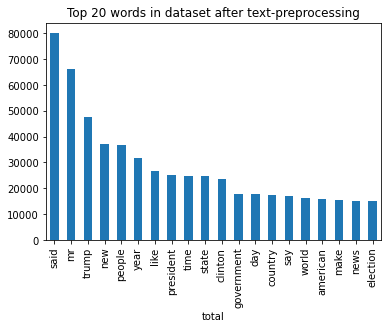

In [49]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus) #sparse matrix
    sum_words = bag_of_words.sum(axis=0) #numpy object array with all frequences of the words
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] #python list of tuples
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #sorted in descending order of frequencis
    return words_freq[:n]
common_words = get_top_n_words(train['total'], 20) #top 20 words
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['total' , 'count'])
df2.groupby('total').sum()['count'].sort_values(ascending=False).plot(
kind='bar', title='Top 20 words in dataset after text-preprocessing')

new york 14704
mr trump 12360
united states 12356
york times 8943
donald trump 8533
hillary clinton 7338
white house 6128
mr trumps 4983
mrs clinton 3359
said mr 2696
year ago 2661
islamic state 2228
obama administration 2129
national security 2059
secretary state 1974
mr obama 1912
trump said 1869
president trump 1867
law enforcement 1865
social medium 1864


<AxesSubplot:title={'center':'Top 20 bi-grams in dataset after text-preprocessing'}, xlabel='total'>

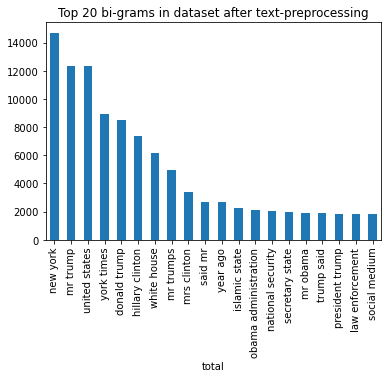

In [50]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(train['total'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['total' , 'count'])
df4.groupby('total').sum()['count'].sort_values(ascending=False).plot(
kind='bar', title='Top 20 bi-grams in dataset after text-preprocessing')

#### Plotting the labels by the word count

In [51]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#2a4fc9')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#2a4fc9')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Reliable')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Unreliable')
    
    fig.suptitle('Fake News', fontsize=24, va='baseline')
    
    fig.tight_layout()

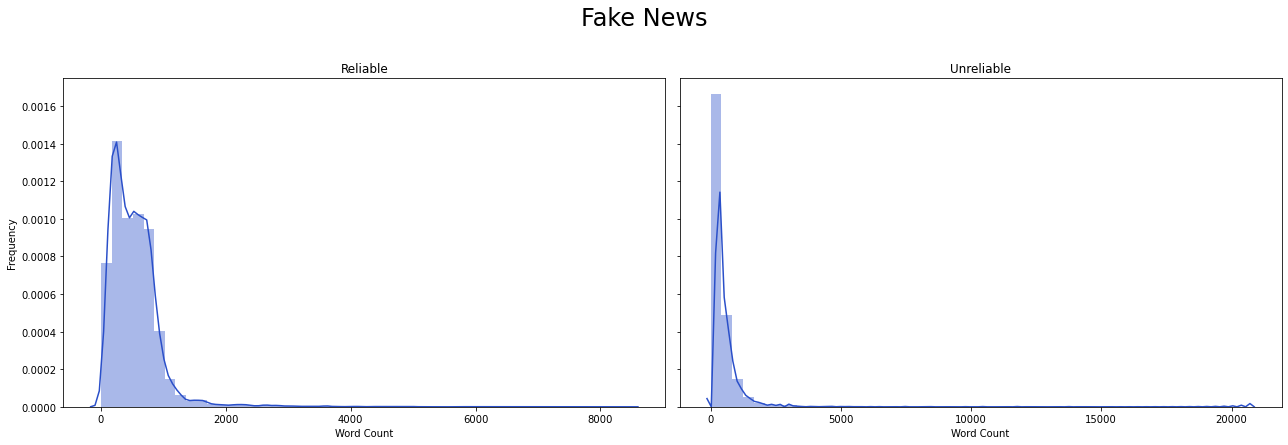

In [52]:
plot_word_number_histogram(train[train['label'] == 0]['total'],train[train['label'] == 1]['total'])

Unreliable news has fewer words than reliable pieces of news

- Word Lengths

#### Plotting the mean word lengths

In [53]:
def plot_word_len_histogram(textno, textye):
    
    # Function for comparing average word length
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)),ax=axes[0], color='#283627',bins=50)
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)),ax=axes[1], color='#283627',bins=50)
    
    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Reliable')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('Unreliable')
    
    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()

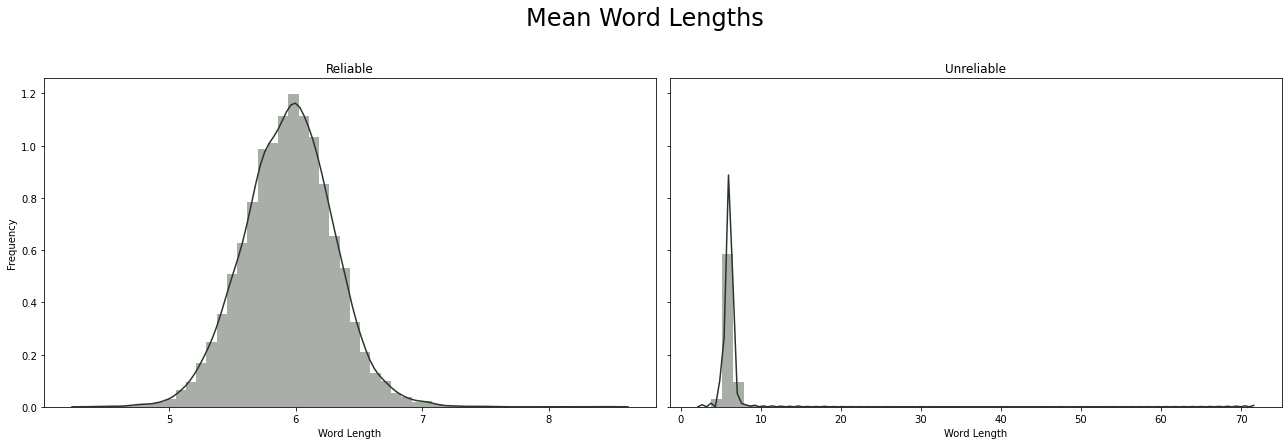

In [54]:
plot_word_len_histogram(train[train['label'] == 0]['total'],
                        train[train['label'] == 1]['total'])

In [55]:
lis_text = [
    
    train[train['label'] == 0]['total'],
    train[train['label'] == 1]['total']
]

lis_title = [
    train[train['label'] == 0]['total'],
    train[train['label'] == 1]['total']
]

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis_text, axes):
    try:
        new = i.str.split()
        new = new.values.tolist()
        corpus = [word.lower() for i in new for word in i]
        dic = defaultdict(int)
        for word in corpus:
            if word in stop:
                dic[word] += 1
        #print(dic)
        top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
        #   print(top)
        x, y = zip(*top)
        df = pd.DataFrame([x, y]).T
        df = df.rename(columns={0: 'Stopword', 1: 'Count'})
        sns.barplot(x='Count', y='Stopword', data=df, palette='plasma', ax=j)
        plt.tight_layout()
    except:
        plt.close()
        print('No stopwords left in texts.')
        break

No stopwords left in texts.


- Most Common Words

['trump', 'people', 'clinton', 'one', 'us', 'would', 'hillary', 'said', 'state', 'new', 'time', 'like', 'year', 'also', 'election', 'world', 'even', 'government', 'war', 'president', 'many', '2016', 'country', 'could'] [18004, 16748, 16682, 16379, 14830, 14506, 12264, 11875, 10844, 10749, 10556, 10378, 10363, 9912, 9752, 9356, 8823, 8646, 8509, 8032, 7955, 7924, 7579, 7514]


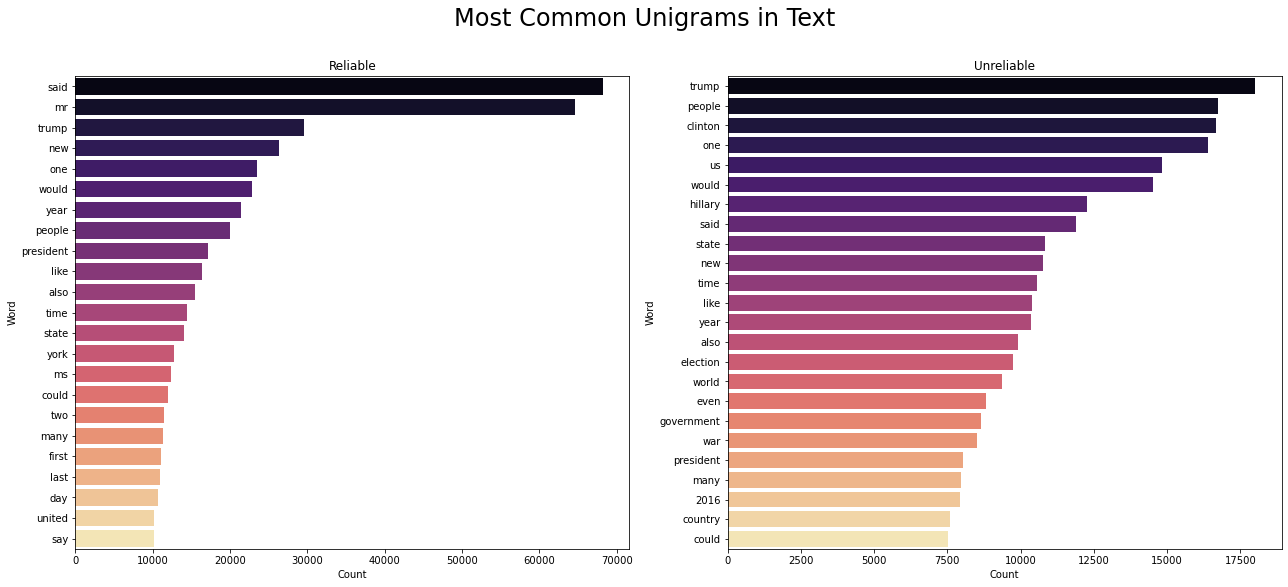

In [57]:
# Displaying most common words.
from collections import Counter, defaultdict

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis_text, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)


    sns.barplot(x=y, y=x, palette='magma', ax=j)
print(x, y)
axes[0].set_title('Reliable')
axes[1].set_title('Unreliable')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams in Text', fontsize=24, va='baseline')
plt.tight_layout()

['trump', 'people', 'clinton', 'one', 'us', 'would', 'hillary', 'said', 'state', 'new', 'time', 'like', 'year', 'also', 'election', 'world', 'even', 'government', 'war', 'president', 'many', '2016', 'country', 'could'] [18004, 16748, 16682, 16379, 14830, 14506, 12264, 11875, 10844, 10749, 10556, 10378, 10363, 9912, 9752, 9356, 8823, 8646, 8509, 8032, 7955, 7924, 7579, 7514]


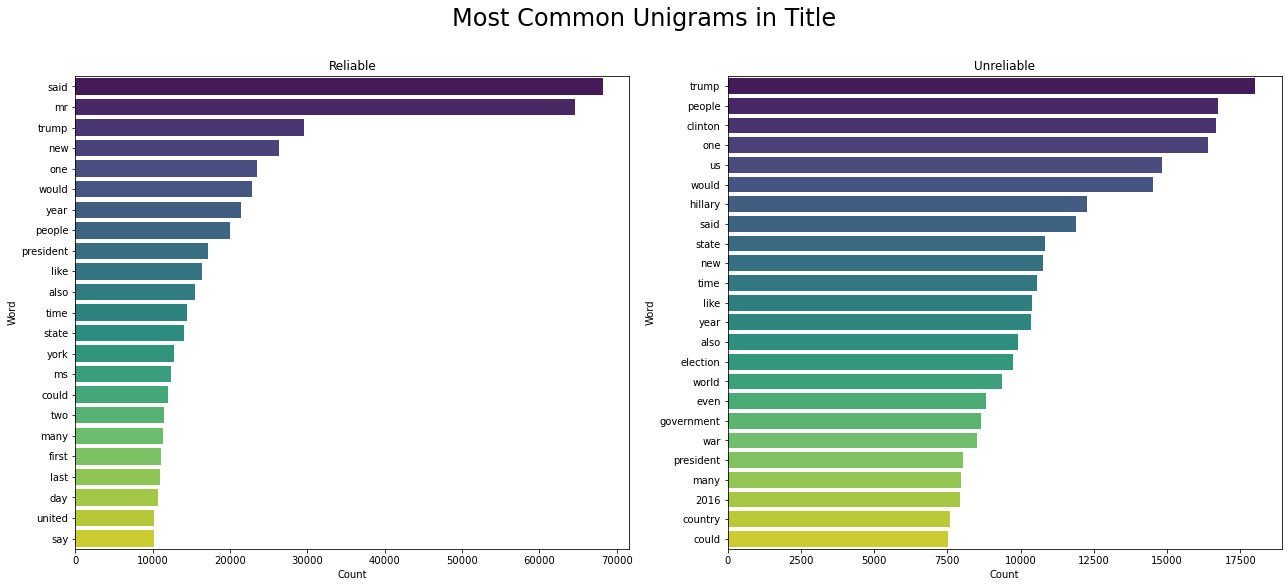

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis_title, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)


    sns.barplot(x=y, y=x, palette='viridis', ax=j)
print(x, y)
axes[0].set_title('Reliable')
axes[1].set_title('Unreliable')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams in Title', fontsize=24, va='baseline')
plt.tight_layout()

- Most Common Bigrams

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
def ngrams(n, title, lis_type):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis_type, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),max_df=0.9,stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Reliable')
        axes[1].set_title('Unreliable')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

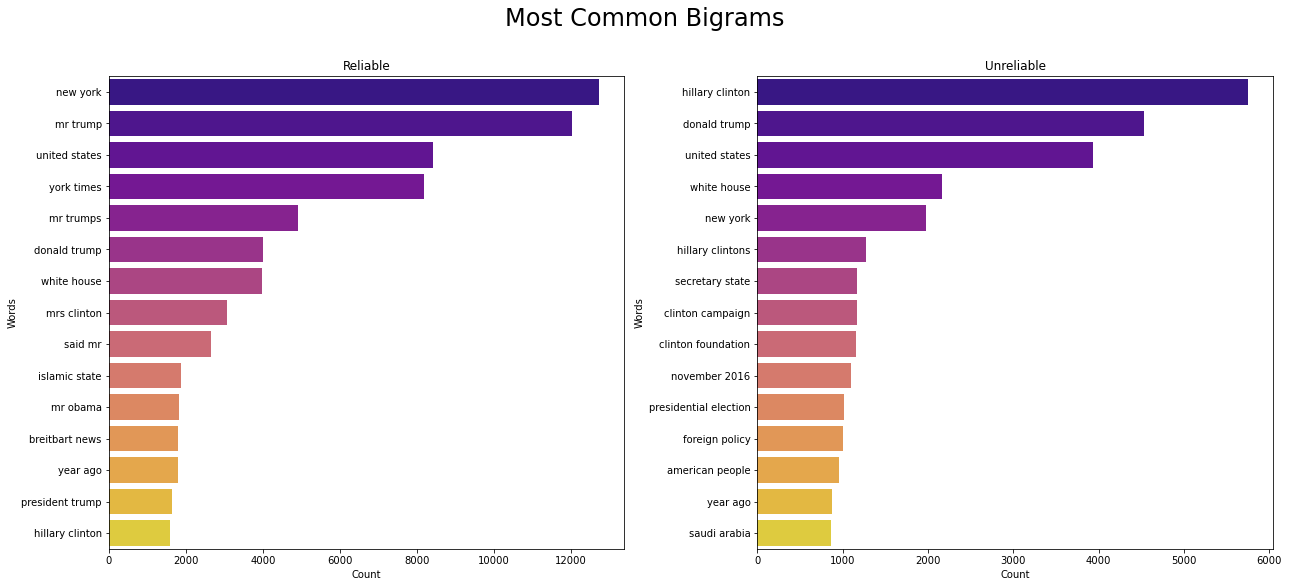

In [60]:
ngrams(2, 'Most Common Bigrams', lis_text)

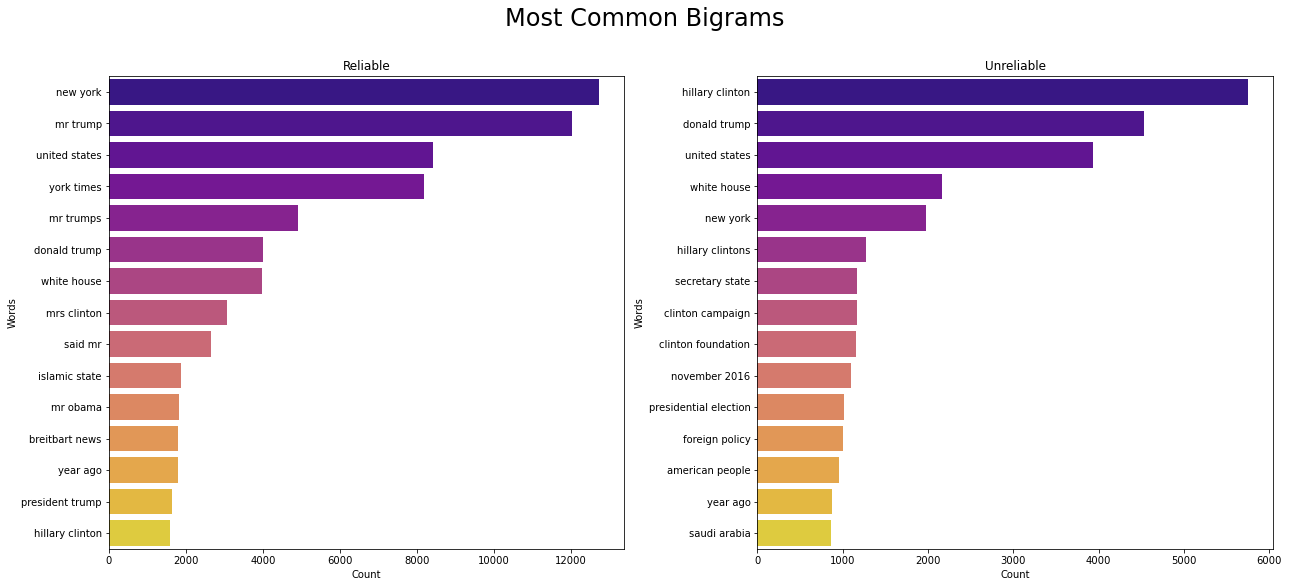

In [61]:
ngrams(2, 'Most Common Bigrams', lis_title)

In [62]:
train.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                               total  
0   house dem aide we didnt even see comeys lette...  
1   flynn hillary clinton big woman campus breitb...  
2   why truth might get you fired consortiumnewsc...  
3   15 civilians killed in single us airstrike ha...  
4   iranian woman jailed fictional unpublished st...

In [63]:
# Obtain the total words present in the dataset
list_of_words = []
for i in train.total:
    for j in i:
        list_of_words.append(j)

In [64]:
len(list_of_words)

68332444

In [65]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

742

In [66]:
# dataframe info
train.info()

# check for null values
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20800 non-null  object
 2   author  20800 non-null  object
 3   text    20800 non-null  object
 4   label   20800 non-null  int64 
 5   total   20800 non-null  object
dtypes: int64(2), object(4)
memory usage: 975.1+ KB


id        0
title     0
author    0
text      0
label     0
total     0
dtype: int64

## We require only the following 2 columns now:
- 'total' --- holds the preprocessed text
- 'label' --- holds the predictions from where the machine will learn

In [67]:
train = train[['total','label']]

In [68]:
train.head()
#column 'total' has the preprocessed text

total  label
0   house dem aide we didnt even see comeys lette...      1
1   flynn hillary clinton big woman campus breitb...      0
2   why truth might get you fired consortiumnewsc...      1
3   15 civilians killed in single us airstrike ha...      1
4   iranian woman jailed fictional unpublished st...      1

Once the data is cleaned, we can use CountVectorizer to convert our data into the format which is required by sklearn

1. CountVectorizer helps in Feature Extraction 
2. It convert a collection of text documents in to a matrix of token counts 

- CountVectorizer produces a sparse matrix.
- CountVectorizer can also take care of stop words. There is an option to add stop_words as an argument in count vectorizer(stop_words) which takes list of stop words and can help us.

### Demo of Countvectorizer

In [69]:
from sklearn.feature_extraction.text import CountVectorizer
train_set = {"the sky is blue", "the sun is bright"}
count_vec = CountVectorizer(max_features = 3)
a = count_vec.fit_transform(train_set)
a.todense()

matrix([[1, 1, 1],
        [0, 1, 1]], dtype=int64)

In [70]:
count_vec.get_feature_names()

['blue', 'is', 'the']

# Applying NLP Techniques

In [71]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [72]:
train['label']

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20800, dtype: int64

In [73]:
X_train = train['total']
Y_train = train['label']

# Bag-of-words / CountVectorizer

In [74]:
# the corpus holds some sentences
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]

# From sklearn, we import Bag of Words model through CountVectorizer. This works like Bag of words
# It is a modified version of Bag of Words and replaces the vector, instead of 1, with the frequency

# Creatibg he object, vectorizer, of module CountVectorizer()
vectorizer = CountVectorizer()

In [75]:
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print("The above words are the unique words and consists of the feature set")

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
The above words are the unique words and consists of the feature set


In [76]:
print("The below matrix will show the frequency of the features in the feature set", end="\n\n")
X.todense()

The below matrix will show the frequency of the features in the feature set



matrix([[0, 1, 1, 1, 0, 0, 1, 0, 1],
        [0, 2, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

# TF-iDF Vectorizer

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_text(features, max_features):
    vectorizer = TfidfVectorizer(stop_words='english', #it will remove the englsh stopwords
                            decode_error='strict',
                            analyzer='word',
                            ngram_range=(1, 2), #unigrams and bi-grams
                            max_features=max_features
                            #max_df=0.5 # Verwendet im ML-Kurs unter Preprocessing                   
                            )
    feature_vec = vectorizer.fit_transform(features)
    return feature_vec.toarray()

In [78]:
tfidf_features = vectorize_text(['hello how are you doing','hi i am doing fine'],30) 
# 30 here is the number of max_features

In [79]:
print("creates some weight for all these words: ", end='\n\n')
tfidf_features

creates some weight for all these words: 



array([[0.44943642, 0.        , 0.        , 0.6316672 , 0.6316672 ,
        0.        , 0.        ],
       [0.33517574, 0.47107781, 0.47107781, 0.        , 0.        ,
        0.47107781, 0.47107781]])

# Applying Feature Extraction using count vectorization and tfidf

The pre-processed text is in X_train and the labels in Y_train as follows (done above):

X_train = train['total'] <br>
Y_train = train['label']

Taking a CountVectorizer, whatever the output of the CountVectorizer is, applying TF-IDF transformer on top of that. Output of CountVectorizer will be some vectors with their Term Frequency. TF-IDF works better with CountVectorizer. So we are using both.

In [80]:
#Feature extraction using count vectorization and tfidf.
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(X_train)
freq_term_matrix = count_vectorizer.transform(X_train)
tfidf = TfidfTransformer(norm="l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

In [81]:
count_vectorizer.vocabulary_.items()

dict_items([('house', 82928), ('dem', 48354), ('aide', 10920), ('we', 188009), ('didnt', 50575), ('even', 61299), ('see', 156042), ('comeys', 39365), ('letter', 102337), ('until', 182075), ('jason', 92242), ('chaffetz', 34648), ('tweeted', 179078), ('it', 91143), ('darrell', 46355), ('lucushouse', 105483), ('by', 31075), ('lucus', 105476), ('october', 124938), ('30', 4229), ('2016', 3200), ('subscribe', 168080), ('stump', 167699), ('american', 13520), ('fork', 67465), ('utah', 182981), ('image', 86571), ('courtesy', 43170), ('michael', 112582), ('jolley', 93578), ('available', 19643), ('creative', 43656), ('commonsby', 39610), ('license', 102867), ('with', 190482), ('apology', 16101), ('keith', 95948), ('olbermann', 125693), ('doubt', 53593), ('worst', 191415), ('person', 132375), ('the', 173473), ('world', 191271), ('weekfbi', 188266), ('director', 51216), ('james', 91985), ('comey', 39357), ('but', 30895), ('according', 8645), ('democratic', 48522), ('look', 104752), ('like', 103231)

In [82]:
print("10 feature names are:", end = '\n\n')
count_vectorizer.get_feature_names()[9000:9010]

10 feature names are:



['acrefeet',
 'acres',
 'acrespopulation',
 'acresworth',
 'acrid',
 'acrimonious',
 'acrimoniously',
 'acrimony',
 'acrisolada',
 'acrobat']

In [83]:
tf_idf_matrix

<20800x220387 sparse matrix of type '<class 'numpy.float64'>'
	with 5987666 stored elements in Compressed Sparse Row format>

In [84]:
tf_idf_matrix.toarray().shape

MemoryError: Unable to allocate 34.2 GiB for an array with shape (20800, 220387) and data type float64

20800 samples and 220387 features were generated so each text sample of holding this number(220387) of length.
Now, text data has been converted into numbers using TF-IDF transformer and CountVectorizer

# Modelling

We will apply transformations on the test data also because after we build the models, we need to predict for the test data and split it into train and test

In [85]:
#split in samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, Y_train, random_state=0)

In [86]:
print(X_train.shape, y_train.shape)

(15600, 220387) (15600,)


In [87]:
print(X_test.shape, y_test.shape)

(5200, 220387) (5200,)


For testing we now have 5200 samples

training data - X_train.shape- 15600 -- these are those samples for which we have the labels also.
Now we will train the model on these 15600 samples and the model is able to give some predictions after that.

We have to test on new(test data) data because the model may always give a correct answer to the training data possibly due to OVERFITTING

For 5200 X_test samples, we know the actual output (label) for these samples
And, once our model is trained, we will test it with these 5200 X_test samples and we will get some predictions. 
We then compare the prediction with the actual labels, then we know that how our model has performed

### PassiveAggressiveClassifier

In [88]:
from sklearn.linear_model import PassiveAggressiveClassifier
model = PassiveAggressiveClassifier(max_iter=10000, random_state=1).fit(X_train, y_train)

#10000 epochs,iterations will stop when (loss > previous_loss - tol)

In [89]:
y_pred_pa = model.predict(X_test)
print(model.score(X_test, y_test))

0.9771153846153846


In [90]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred_pa))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2564
           1       0.97      0.98      0.98      2636

    accuracy                           0.98      5200
   macro avg       0.98      0.98      0.98      5200
weighted avg       0.98      0.98      0.98      5200



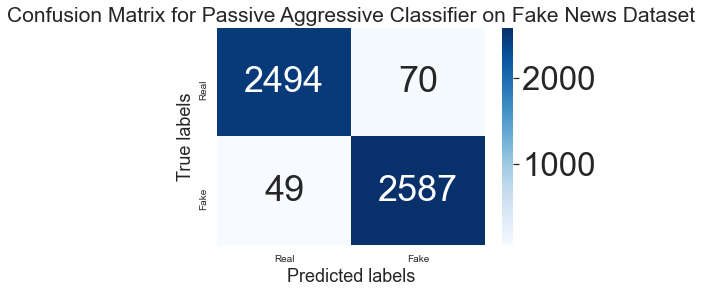

<Figure size 432x288 with 0 Axes>

In [92]:

cm = confusion_matrix(y_test, y_pred_pa)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix for Passive Aggressive Classifier on Fake News Dataset', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Real', 'Fake']);
ax.yaxis.set_ticklabels(['Real', 'Fake']);
plt.show()
plt.savefig('PassiveAgressive.png')

# Multi Layer Perceptron	

In [93]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [94]:
clf.predict_proba(X_test[:1])

array([[9.99506512e-01, 4.93488449e-04]])

In [95]:
pred_ann= clf.predict(X_test)
clf.score(X_test, y_test)

0.9721153846153846

In [96]:
print(classification_report(y_test,pred_ann))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2564
           1       0.97      0.97      0.97      2636

    accuracy                           0.97      5200
   macro avg       0.97      0.97      0.97      5200
weighted avg       0.97      0.97      0.97      5200



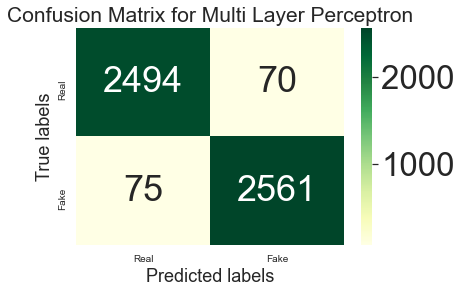

<Figure size 432x288 with 0 Axes>

In [97]:
cm = confusion_matrix(y_test, pred_ann)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="YlGn", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix for Multi Layer Perceptron', fontdict=title_font);

ax.tick_params(labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Real', 'Fake']);
ax.yaxis.set_ticklabels(['Real', 'Fake']);
plt.show()

In [98]:
print(pred_ann)

[0 1 1 ... 0 1 1]


# Logistic Regression

Regularisation parameter. Regularisation is used to avoid the overfitting when we have a lot of features, like here for each sample(15600), we have (220387) features. A regularisation parameter should be as low as possible so that we can remove the overfitting,  It can be fine tuned again.

In [99]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5, random_state=110, max_iter=300)

In [100]:
logreg.fit(X_train, y_train)

LogisticRegression(C=100000.0, max_iter=300, random_state=110)

In [101]:
pred = logreg.predict(X_test)

print('Accuracy of Logistic Regression on test set: {:.5f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression on test set: 0.97788


In [102]:
print(pred)

[0 1 1 ... 0 1 0]


In [103]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2564
           1       0.97      0.98      0.98      2636

    accuracy                           0.98      5200
   macro avg       0.98      0.98      0.98      5200
weighted avg       0.98      0.98      0.98      5200



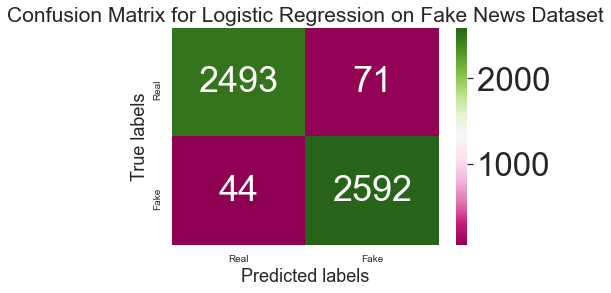

<Figure size 432x288 with 0 Axes>

In [104]:
cm = confusion_matrix(y_test, pred)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="PiYG", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix for Logistic Regression', fontdict=title_font);

ax.tick_params(labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Real', 'Fake']);
ax.yaxis.set_ticklabels(['Real', 'Fake']);
plt.show()

# MultinomialNB

Multinomial Naive Bayes Classifier works on Conditional Probabilities

In [105]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)
pred_NB = NB.predict(X_test)
print('Accuracy of MultinomialNB classifier on test set: {:.2f}'
     .format(NB.score(X_test, y_test)))

Accuracy of MultinomialNB classifier on test set: 0.83


In [106]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,pred_NB))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      2564
           1       1.00      0.68      0.81      2636

    accuracy                           0.83      5200
   macro avg       0.87      0.84      0.83      5200
weighted avg       0.87      0.83      0.83      5200



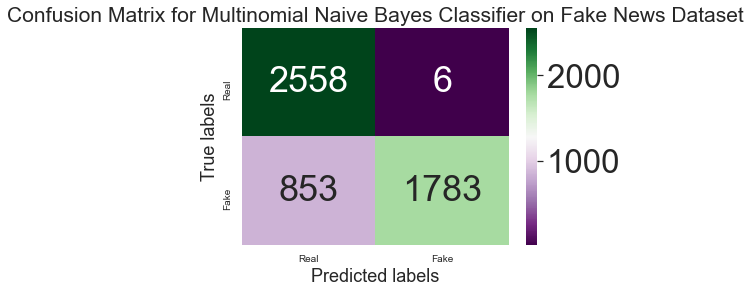

<Figure size 432x288 with 0 Axes>

In [107]:
cm = confusion_matrix(y_test, pred_NB)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="PRGn", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix for Multinomial Naive Bayes Classifier on Fake News Dataset', fontdict=title_font);

ax.tick_params(labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Real', 'Fake']);
ax.yaxis.set_ticklabels(['Real', 'Fake']);
plt.show()


# Decision Tree

In [108]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
pred_dt = DT.predict(X_test)
DT.score(X_test, y_test)

0.9676923076923077

In [109]:
print(classification_report(y_test,pred_dt))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2564
           1       0.96      0.97      0.97      2636

    accuracy                           0.97      5200
   macro avg       0.97      0.97      0.97      5200
weighted avg       0.97      0.97      0.97      5200



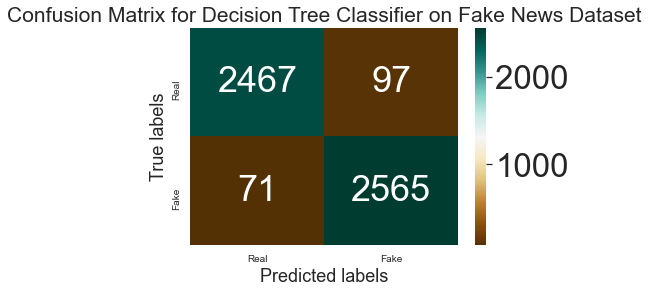

<Figure size 432x288 with 0 Axes>

In [110]:
cm = confusion_matrix(y_test, pred_dt)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="BrBG", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix for Decision Tree Classifier on Fake News Dataset', fontdict=title_font);

ax.tick_params(labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Real', 'Fake']);
ax.yaxis.set_ticklabels(['Real', 'Fake']);
plt.show()


# GradientBoostingClassifier

In [111]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(X_train, y_train)
pred_gbc = GBC.predict(X_test)
GBC.score(X_test, y_test)

0.9709615384615384

In [112]:
print(classification_report(y_test, pred_gbc))
print(GBC.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2564
           1       0.96      0.98      0.97      2636

    accuracy                           0.97      5200
   macro avg       0.97      0.97      0.97      5200
weighted avg       0.97      0.97      0.97      5200

0.9709615384615384


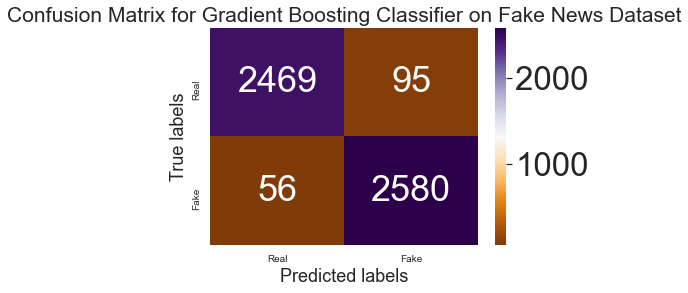

<Figure size 432x288 with 0 Axes>

In [113]:
cm = confusion_matrix(y_test, pred_gbc)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="PuOr", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix for Gradient Boosting Classifier on Fake News Dataset', fontdict=title_font);

ax.tick_params(labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Real', 'Fake']);
ax.yaxis.set_ticklabels(['Real', 'Fake']);
plt.show()

# Random Forest Classifier

In [114]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=50, criterion="entropy")
RFC.fit(X_train, y_train)
pred_RFC = RFC.predict(X_test)

In [115]:
print(RFC.score(X_test, y_test))
print(classification_report(y_test, pred_RFC))

0.9307692307692308
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2564
           1       0.96      0.90      0.93      2636

    accuracy                           0.93      5200
   macro avg       0.93      0.93      0.93      5200
weighted avg       0.93      0.93      0.93      5200



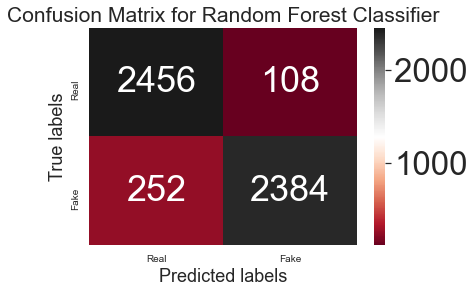

<Figure size 432x288 with 0 Axes>

In [116]:
cm = confusion_matrix(y_test, pred_RFC)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="RdGy", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix for Random Forest Classifier', fontdict=title_font);

ax.tick_params(labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Real', 'Fake']);
ax.yaxis.set_ticklabels(['Real', 'Fake']);
plt.show()

# KNN

In [117]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix


knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)

In [118]:
print(knn.score(X_test, y_test))
print(classification_report(y_test, pred_knn))

0.8546153846153847
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      2564
           1       0.91      0.79      0.85      2636

    accuracy                           0.85      5200
   macro avg       0.86      0.86      0.85      5200
weighted avg       0.86      0.85      0.85      5200



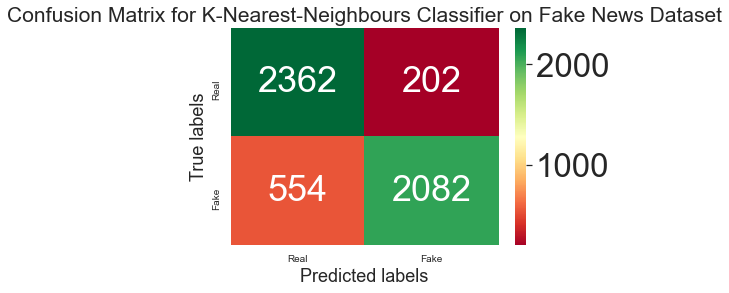

<Figure size 432x288 with 0 Axes>

In [119]:
cm = confusion_matrix(y_test, pred_knn)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="RdYlGn", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix for K-Nearest-Neighbours Classifier on Fake News Dataset', fontdict=title_font);

ax.tick_params(labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Real', 'Fake']);
ax.yaxis.set_ticklabels(['Real', 'Fake']);
plt.show()

In [120]:
neighbors = np.arange(1, 15)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

In [121]:
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

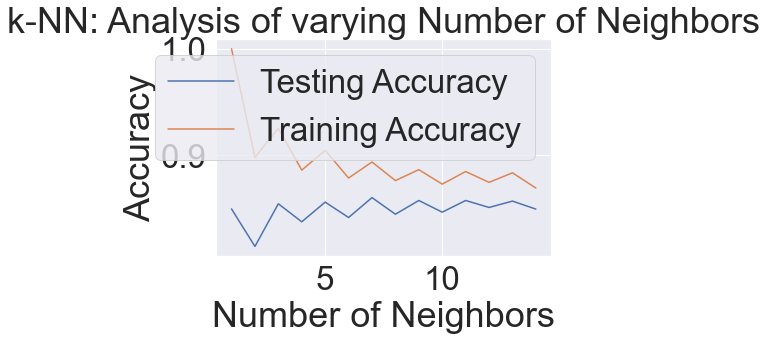

In [122]:
plt.title('k-NN: Analysis of varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [123]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)

In [124]:
print(knn.score(X_test, y_test))
print(classification_report(y_test, pred_knn))

0.8603846153846154
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2564
           1       0.93      0.78      0.85      2636

    accuracy                           0.86      5200
   macro avg       0.87      0.86      0.86      5200
weighted avg       0.87      0.86      0.86      5200



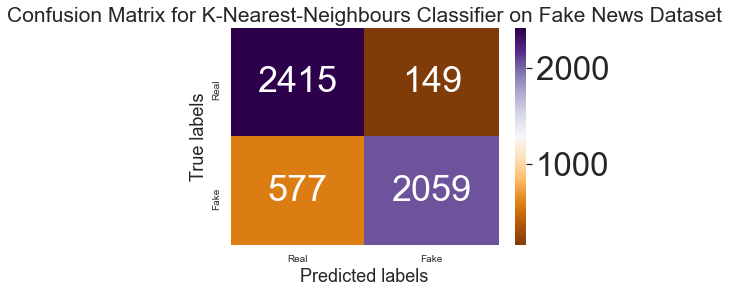

In [126]:
cm = confusion_matrix(y_test, pred_knn)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="PuOr", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix for K-Nearest-Neighbours Classifier on Fake News Dataset', fontdict=title_font);

ax.tick_params(labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Real', 'Fake']);
ax.yaxis.set_ticklabels(['Real', 'Fake']);
plt.show()

# SVM -Linear Kernel

In [127]:
from sklearn import svm, metrics

svm_ = svm.SVC(kernel="linear")
svm_.fit(X_train, y_train)
pred_svm = svm_.predict(X_test)

In [128]:
print(svm_.score(X_test, y_test))
print(classification_report(y_test, pred_svm))

0.9792307692307692
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2564
           1       0.98      0.98      0.98      2636

    accuracy                           0.98      5200
   macro avg       0.98      0.98      0.98      5200
weighted avg       0.98      0.98      0.98      5200



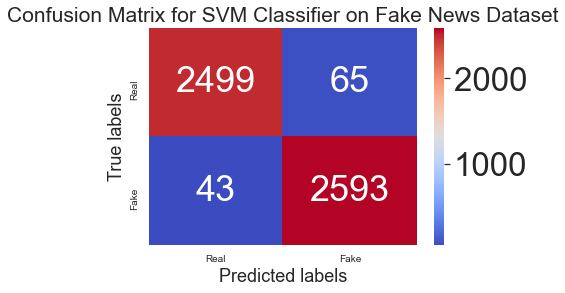

In [129]:
cm = confusion_matrix(y_test, pred_svm)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="coolwarm", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix for SVM Classifier on Fake News Dataset', fontdict=title_font);

ax.tick_params(labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Real', 'Fake']);
ax.yaxis.set_ticklabels(['Real', 'Fake']);
plt.show()

# AdaBoost

In [130]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

clf = AdaBoostClassifier(n_estimators=100, random_state=0)

In [131]:
clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [132]:
pred_adaBoost = clf.predict(X_test)
print(clf.score(X_test, y_test))

0.9709615384615384


In [133]:
print(classification_report(y_test,pred_adaBoost))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2564
           1       0.97      0.97      0.97      2636

    accuracy                           0.97      5200
   macro avg       0.97      0.97      0.97      5200
weighted avg       0.97      0.97      0.97      5200



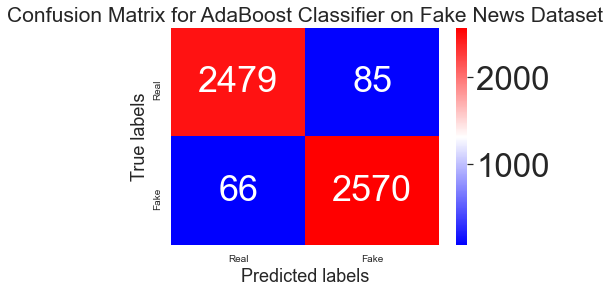

In [134]:
cm = confusion_matrix(y_test, pred_adaBoost)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="bwr", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix for AdaBoost Classifier on Fake News Dataset', fontdict=title_font);

ax.tick_params(labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Real', 'Fake']);
ax.yaxis.set_ticklabels(['Real', 'Fake']);
plt.show()

# XGBoost

In [135]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)

In [136]:
pred_XGBoost = clf.predict(X_test)

In [137]:
clf.score(X_test, y_test)

0.9661538461538461

In [138]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,pred_XGBoost))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2564
           1       0.96      0.97      0.97      2636

    accuracy                           0.97      5200
   macro avg       0.97      0.97      0.97      5200
weighted avg       0.97      0.97      0.97      5200



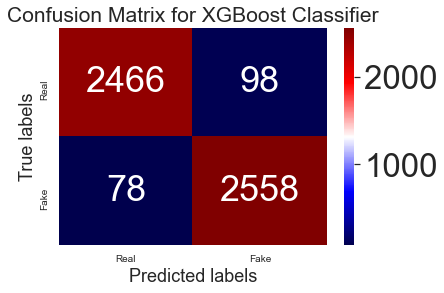

In [139]:
cm = confusion_matrix(y_test, pred_XGBoost)

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="seismic", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix for XGBoost Classifier', fontdict=title_font);

ax.tick_params(labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Real', 'Fake']);
ax.yaxis.set_ticklabels(['Real', 'Fake']);
plt.show()